## Import Modules

In [ ]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from functools import reduce
import math
import ee
import geemap.core as geemap
from pandas.tseries.offsets import DateOffset

## Variables

In [484]:
# Weather and Soil
WEATHER_PATH = "data/modelling/baseline_datasets/processed/20250710_openmeteo_daily.csv"
SOIL_PATH = "data/modelling/baseline_datasets/processed/20250711_lucas_cleaned.csv"

SENTINEL_2_PATH = "data/modelling/365day_datasets/processed/20250803_sentinel2_365days_mean.csv"
SENTINEL_1_PATH = "data/modelling/baseline_datasets/processed/20250722_sentinel_1_mean_band_values_all_images.csv"

LANDSAT_PATH = "data/modelling/365day_datasets/processed/20250807_landsat_band_values_365days.csv"

# Load all Files

In [485]:
# Function to read text files as json
def read_txt_as_df(filepath):
    rows = []
    with open(filepath, 'r+') as f:
        for line in f:
            try: 
                data = json.loads(line)
                if isinstance(data, dict):
                    rows.append(data)
            except json.JSONDecodeError:
                continue

    # Convert to a dataframe
    df = pd.DataFrame(rows)
    return df

In [486]:
# Sentinel Surface Reflectance
sr = pd.read_csv(SENTINEL_2_PATH)
s1 = pd.read_csv(SENTINEL_1_PATH)

# Landsat Cloud Cover
landsat = pd.read_csv(LANDSAT_PATH)

# Read weather
weather = pd.read_csv(WEATHER_PATH)

# Read Soil
soil = pd.read_csv(SOIL_PATH)

## Initial Transformations

In [487]:
# Select only columns of interest
cols_to_keep = ['point_id', 'survey_date', 'image_date', 'VV_mean', 'VH_mean',
                # 'image_id', 'VH_array', 'VH_center', 'VV_array', 'VV_center', 'days_diff', 
                # 'VV_diff', 'VH_diff'
                ]
s1 = s1[cols_to_keep]

In [488]:
# Convert to datetime format
sr['survey_date'] = pd.to_datetime(sr['survey_date'])
sr['image_date'] = pd.to_datetime(sr['image_date'])
s1['survey_date'] = pd.to_datetime(s1['survey_date'])
s1['image_date'] = pd.to_datetime(s1['image_date'])
landsat['survey_date'] = pd.to_datetime(landsat['survey_date'])
landsat['image_date'] = pd.to_datetime(landsat['image_date'])

# Create days_diff column for sentinel
sr['days_diff'] = (sr['survey_date'] - sr['image_date']).dt.days
s1['days_diff'] = (s1['survey_date'] - s1['image_date']).dt.days

# Sentinel images over 0 days diff
sr = sr[sr['days_diff'] >= 0]
sr = sr[sr['days_diff'] >= 0]

In [489]:
# NDVI index for LANDSAT
landsat['NDVI'] = (landsat['SR_B5'] - landsat['SR_B4']) / (landsat['SR_B5'] + landsat['SR_B4'])

# SAVI Index for Landsat
landsat['SAVI'] = ((landsat['SR_B5'] - landsat['SR_B4']) / (landsat['SR_B5'] + landsat['SR_B4'] + 0.5)) * 1.5

# Select one of the following methods to aggregate satellite imagery

Change the time windows - variables are at the top of each cell. 

## 1. Most Recent Image, no cloud filtering

In [432]:
# LANDSAT ------------------------------------------------------------------------------
# Select clear images only
print(f"Number of point IDs in original dataframe: {landsat['point_id'].nunique()}")

# Select the most recent clear image
ls_idx = landsat.groupby(['point_id', 'survey_date'])['days_diff'].idxmin()
ls_filtered = landsat.loc[ls_idx].reset_index(drop=True)

# SENTINEL 2 --------------------------------------------------------------------------- 
print(f"Number of point IDs in original dataframe: {sr['point_id'].nunique()}")
sen_idx = sr.groupby(['point_id', 'survey_date'])['days_diff'].idxmin()
sen_filtered = sr.loc[sen_idx].reset_index(drop=True)

# Sentinel 
s1_idx = s1.groupby(['point_id', 'survey_date'])['days_diff'].idxmin()
s1_filtered = s1.loc[s1_idx].reset_index(drop=True)

print(f"Length of Landsat: {len(ls_filtered)}")
print(f"Length of Sentinel: {len(sen_filtered)}")
print(f"Length of Sentinel 1: {len(s1_filtered)}")

Number of point IDs in original dataframe: 15973
Number of point IDs in original dataframe: 15954
Length of Landsat: 15973
Length of Sentinel: 15954
Length of Sentinel 1: 15939


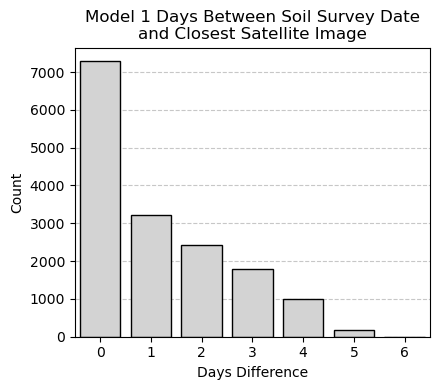

In [433]:
dd_df = s1_filtered.groupby(['days_diff']).agg('count').reset_index()

plt.figure(figsize=(4.5,4))
ax = sns.barplot(dd_df, x='days_diff', y='point_id', color='lightgrey', edgecolor='black')
plt.xlabel('Days Difference')
plt.ylabel('Count')
plt.title("Model 1 Days Between Soil Survey Date\nand Closest Satellite Image")
plt.tight_layout()
ax.grid(True, linestyle='--', alpha=0.7, axis='y')
ax.set_axisbelow(True)
plt.savefig("graphs/results/m1_daysdiff.png", dpi=300)
plt.show()

## (Not Used in Modelling) Most Recent Cloud Free Image

In [8]:
days_window = 62
cloud_thresh = 12

keys = ['point_id', 'survey_date']

# LANDSAT ------------------------------------------------------------------------------
# Select clear images only
print(f"Number of point IDs in original dataframe: {landsat['point_id'].nunique()}")
ls_window = landsat[landsat['days_diff'] <= days_window]
ls_clear = ls_window[ls_window['clear'] == 1]
print(f"Number of points with at least 1 clear image: {ls_clear['point_id'].nunique()}")

# Select the most recent clear image
# Get the least cloudy image within the month window
ls_last_month = ls_clear.sort_values(by=['cloud', 'days_diff'], ascending=[True, True])
ls_filtered = ls_last_month.drop_duplicates(subset=keys, keep='first')
ls_filtered = ls_filtered.drop(columns=['clear', 'cloud', 'cloud_effects'])

# SENTINEL 2 --------------------------------------------------------------------------- 
print(f"Number of point IDs in original dataframe: {sr['point_id'].nunique()}")
sr_window = sr[sr['days_diff'] <= days_window]
sr_clear = sr_window[sr_window['cloud_mean'] <= cloud_thresh]
print(f"Number of points with at least 1 clear image: {sr_clear['point_id'].nunique()}")
sr_clear = sr_clear.sort_values(by=['cloud_mean', 'days_diff'], ascending=[True, True])
sen_filtered = sr_clear.drop_duplicates(subset=keys, keep='first')

# Sentinel 
s1_idx = s1.groupby(['point_id', 'survey_date'])['days_diff'].idxmin()
s1_filtered = s1.loc[s1_idx].reset_index(drop=True)

print(f"Length of Landsat: {len(ls_filtered)}")
print(f"Length of Sentinel: {len(sen_filtered)}")
print(f"Length of Sentinel 1: {len(s1_filtered)}")

Number of point IDs in original dataframe: 15973
Number of points with at least 1 clear image: 14916
Number of point IDs in original dataframe: 15954
Number of points with at least 1 clear image: 15475
Length of Landsat: 14916
Length of Sentinel: 15475
Length of Sentinel 1: 15939


## 2. Median/Median of Low Cloud Images Throughout a Time Window (needs specifying)

In [ ]:
ls_days = 365
sr_days = 365
agg_type = 'mean'

# LANDSAT ------------------------------------------------------------------------------
# Select clear images only
print(f"Number of point IDs in original dataframe: {landsat['point_id'].nunique()}")
ls_last_month = landsat[landsat['days_diff'] <= ls_days] # Filter by date range
ls_clear = ls_last_month[ls_last_month['clear'] == True]
print(f"Number of points with at least 1 clear image: {ls_clear['point_id'].nunique()}")

# Select the median values for every column
ls_g = ls_clear.groupby(['point_id', 'survey_date'])
ls_filtered = ls_g.mean(numeric_only=True).join(ls_g.size().rename("image_count")).reset_index()
ls_filtered = ls_filtered.drop(columns=['clear', 'cloud', 'cloud_effects'])

# SENTINEL 2 --------------------------------------------------------------------------- 
print(f"Number of point IDs in original dataframe: {sr['point_id'].nunique()}")
sr_last_month = sr[sr['days_diff'] <= sr_days] # Filter by date range
sr_clear = sr_last_month[sr_last_month['cloud_mean'] <= 20]
print(f"Number of points with at least 1 clear image: {sr_last_month['point_id'].nunique()}")

sr_clear = sr_clear.drop(columns='SCL_mode')
sr_g = sr_clear.groupby(['point_id', 'survey_date'])
sen_filtered = sr_g.mean(numeric_only=True).join(sr_g.size().rename("image_count")).reset_index()
# sen_filtered = sr_clear.loc[sen_idx].reset_index(drop=True)

# Sentinel 
s1_filtered = s1.groupby(['point_id', 'survey_date']).agg(agg_type).reset_index()

print(f"Length of Landsat: {len(ls_filtered)}")
print(f"Length of Sentinel: {len(sen_filtered)}")
print(f"Length of Sentinel 1: {len(s1_filtered)}")


Number of point IDs in original dataframe: 15973
Number of points with at least 1 clear image: 15930
Number of point IDs in original dataframe: 15954
Number of points with at least 1 clear image: 15954
Length of Landsat: 15930
Length of Sentinel: 15931
Length of Sentinel 1: 15939


In [239]:
# Number of images per point - LANDSAT
ls_stats = ls_clear.groupby(['point_id', 'survey_date']).agg('count').reset_index().rename(columns={'image_date': 'ls_images_per_point'})
sr_stats = sr_clear.groupby(['point_id', 'survey_date']).agg('count').reset_index().rename(columns={'image_date': 'sr_images_per_point'})
stats_df = pd.DataFrame(ls_stats['ls_images_per_point'].describe())
stats_df['sr_images_per_point'] = pd.DataFrame(sr_stats['sr_images_per_point'].describe())['sr_images_per_point']
stats_df['sr_median_cloud_mean'] = pd.DataFrame(sen_filtered['cloud_mean'].describe())['cloud_mean']
stats_df['sr_median_days_diff'] = pd.DataFrame(sen_filtered['days_diff'].describe())['days_diff']
stats_df['ls_median_days_diff'] = pd.DataFrame(ls_filtered['days_diff'].describe())['days_diff']

In [240]:
stats_df

,ls_images_per_point,sr_images_per_point,sr_median_cloud_mean,sr_median_days_diff,ls_median_days_diff
count,15930.000000,15931.000000,15931.000000,15931.000000,15930.000000
mean,14.775518,31.727010,6.275991,139.901163,171.404800
std,7.048834,15.492869,2.001987,37.790377,45.704662
min,1.000000,1.000000,0.000000,0.000000,1.000000
25%,10.000000,20.000000,4.875210,120.061111,145.308333
50%,13.000000,30.000000,6.096618,145.333333,179.181818
75%,18.000000,41.000000,7.450455,165.173141,202.529310
max,39.000000,91.000000,19.444444,296.400000,328.000000


## 3. Least Cloudy Image within a set time window

In [399]:
days_window = 62

keys = ['point_id', 'survey_date']

# LANDSAT ------------------------------------------------------------------------------
# Select clear images only
print(f"Number of point IDs in original dataframe: {landsat['point_id'].nunique()}")
ls_last_month = landsat[landsat['days_diff'] <= days_window]

# Get the least cloudy image within the month window
ls_last_month = ls_last_month.sort_values(by=['cloud', 'days_diff'], ascending=[True, True])
ls_filtered = ls_last_month.drop_duplicates(subset=keys, keep='first')

# SENTINEL 2 --------------------------------------------------------------------------- 
print(f"Number of point IDs in original dataframe: {sr['point_id'].nunique()}")
sr_last_month = sr[sr['days_diff'] <= days_window]
sr_last_month = sr_last_month.sort_values(by=['cloud_mean', 'days_diff'], ascending=[True, True])
sen_filtered = sr_last_month.drop_duplicates(subset=keys, keep='first')

# Sentinel 
s1_idx = s1.groupby(['point_id', 'survey_date'])['days_diff'].idxmin()
s1_filtered = s1.loc[s1_idx].reset_index(drop=True)

print(f"Length of Landsat: {len(ls_filtered)}")
print(f"Length of Sentinel: {len(sen_filtered)}")
print(f"Length of Sentinel 1: {len(s1_filtered)}")

Number of point IDs in original dataframe: 15973
Number of point IDs in original dataframe: 15954
Length of Landsat: 15765
Length of Sentinel: 15926
Length of Sentinel 1: 15939


# Merge Sentinel and Landsat

In [435]:
# RENAME COLUMNS FOR LANDSAT AND SENTINEL
sen_filtered = sen_filtered.add_prefix("sr_")
s1_filtered = s1_filtered.add_prefix("s1_")
ls_filtered = ls_filtered.add_prefix("ls_")
satellite = sen_filtered.merge(ls_filtered, how="inner", left_on=['sr_point_id', 'sr_survey_date'],
                      right_on=['ls_point_id', 'ls_survey_date'])

satellite = satellite.merge(s1_filtered, how="inner", left_on=['ls_point_id', 'ls_survey_date'],
                      right_on=['s1_point_id', 's1_survey_date'])
print(f"Size of merged dataframe: {len(satellite)}")

# Drop duplicate columns and rename
satellite = satellite.drop(columns=['ls_point_id', 'ls_survey_date', 's1_point_id', 's1_survey_date',
                                    # 'sr_image_date', 
                                    'ls_image_date', 's1_image_date'], errors='ignore')
satellite = satellite.rename(columns={'sr_point_id': 'point_id',
                                      'sr_survey_date': 'survey_date'})

Size of merged dataframe: 15627


## Soil Data

### Replace Yes or No Features with `True` and `False`

In [463]:
soil = soil.replace({'Yes': True,
                     'No': False})

# Convert date to datetime format
soil['SURVEY_DATE'] = pd.to_datetime(soil['SURVEY_DATE'])

# Rename columns
soil = soil.rename(columns={'SURVEY_DATE': 'survey_date',
                            'POINTID': 'point_id'})

# Select relevant columns
cols_to_use = ['point_id', 
               'survey_date', 
               'Elev', 'LC0_Desc', 'LU1_Desc', 
               'parcel_area_ha', 'crop_residues', 'lm_grass_margins', 'grazing',
               'LC1_Grouped',
               'soil_stones_perc', 
               'OC', 'N', 
               # 'log_OC', 'log_N', 'LC1_Desc', 'gps_lat', 'gps_long', 
            #    'lc1_perc', 'country_name', 'coord_tuple', 'geometry', 
            #    'log_OC_scaled', 'log_N_scaled',
               ]


In [437]:
TOP_FEATURES_FILE = "experiment_tracking/feature_importance/top_features.csv"
top_features = pd.read_csv(TOP_FEATURES_FILE)
top_features = top_features.sort_values(by='OC Ranking', ascending=True)
features_in_order = top_features['Feature'].tolist()

top_features = ['N', 'OC', 'point_id', 'survey_date', 'image_date'] + features_in_order

In [438]:
top_soil = [feature for feature in cols_to_use if feature in top_features]
soil = soil[top_soil]

## Merge Satellite and Soil

In [439]:
sat_soil = soil.merge(satellite, how="inner", on=['point_id', 'survey_date'])
print(f"Merged dataset length: {len(sat_soil)}")

# Drop duplicates
sat_soil = sat_soil.dropna(axis=0)
print(f"Length of dataframe after removing null rows: {len(sat_soil)}")

Merged dataset length: 15627
Length of dataframe after removing null rows: 15627


## Select Weather Data

In [444]:
# Read weather
weather = pd.read_csv(WEATHER_PATH)

In [446]:
wthr = weather.copy()

weather['date'] = pd.to_datetime(weather['date'])
weather['survey_date'] = pd.to_datetime(weather['survey_date'])

weather_to_keep = [
                   'temperature_2m_max', 
                  #  'temperature_2m_min', 

                  #  'precipitation_sum', 
                   'rain_sum', 
                  #  'sunshine_duration', 
                   'daylight_duration',

                  #  'wind_speed_10m_max', 
                   'wind_gusts_10m_max',
                   
                  #  'shortwave_radiation_sum', 
                   'et0_fao_evapotranspiration', 
                   'date', 'point_id', 'survey_date', 

                  #  'relative_humidity_2m_mean', 
                   'relative_humidity_2m_min', 'relative_humidity_2m_max',

                  #  'cloud_cover_mean', 
                   'cloud_cover_min', 'cloud_cover_max',

                #    'soil_temperature_0_to_7cm_max', 
                   'soil_temperature_7_to_28cm_max',
                #    'soil_temperature_0_to_7cm_mean', 'soil_temperature_0_to_7cm_min',
                #    'soil_temperature_7_to_28cm_mean', 'soil_temperature_7_to_28cm_min',

                   'soil_moisture_0_to_7cm_mean', 
                #    'soil_moisture_0_to_7cm_min', 'soil_moisture_0_to_7cm_max', 
                #    'soil_moisture_7_to_28cm_mean',
                #    'soil_moisture_7_to_28cm_min', 'soil_moisture_7_to_28cm_max'
                   ]


### Select Columns and Aggregate some in two week intervals

In [449]:
# Columns to aggregate
agg_cols = ['rain_sum', 'wind_gusts_10m_max', 'cloud_cover_min', 'cloud_cover_max',]
agg_cols = [col for col in agg_cols if col in weather.columns.tolist()]

windows = [0, 14, 28]
window_size = 14
group_cols = ['point_id', 'survey_date']
cols_not_agged = [col for col in weather_to_keep if not col in agg_cols]

# Get days between weather data and survey date
weather['days_diff'] = (weather['survey_date'] - weather['date']).dt.days

# Create new dataframe with columns where only day of survey date is being used and select them only
all_agg_rows = weather[weather['days_diff'] == 0][cols_not_agged].copy()  

for window in windows:
    window_df = weather.loc[(weather['days_diff'] > window - window_size) & (weather['days_diff'] <= window)] # Select rows in window
    window_df = window_df[group_cols + agg_cols]
    window_df = window_df.groupby(group_cols, as_index=False).agg('mean') # Aggregate by mean
    week = int(window/7) # Calculate week number aggregation
    column_list = window_df.columns.drop(['point_id', 'survey_date']) # select columns (aggregated only)
    window_df.columns = [f"w{week}_mean_{col}" if col in agg_cols else col for col in window_df.columns] # create new column names
    all_agg_rows = all_agg_rows.merge(window_df, on=['point_id', 'survey_date']) # Rejoin with original df

weather = all_agg_rows.copy()
weather = weather.drop(columns=['date'])

## Merge all Datasets

In [451]:
matching_points = len(set(sat_soil['point_id'].unique().tolist() + weather['point_id'].unique().tolist()))
print(f"Number of matching points between weather, soil and satellite data: {matching_points}")

merged = sat_soil.merge(weather, how="inner", on=['point_id'])

print(f"Length of the merged dataset: {len(merged)}")

Number of matching points between weather, soil and satellite data: 15954
Length of the merged dataset: 15627


# Final Processing

## Select Columns

In [452]:
df = merged.copy()

In [453]:
cols_to_drop = ['survey_date_x', 'survey_date_y',
                'sr_SCL_mode', 'sr_image_date']
df = df.drop(columns=cols_to_drop, errors='ignore')

In [454]:
unscaled = df.copy()

## Min Max Scaler

In [421]:
numeric_cols = df.select_dtypes(include='number').columns.tolist()

targets = ['OC', 'N']
binary_cols = [col for col in numeric_cols if df[col].nunique() == 2]
id_cols = ['point_id']  # Add other IDs if needed
others = ['sr_SCL_mode']

to_scale = [col for col in numeric_cols if col not in others + targets + binary_cols + id_cols]

# Apply scaler
scaler = MinMaxScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])

## Correlations

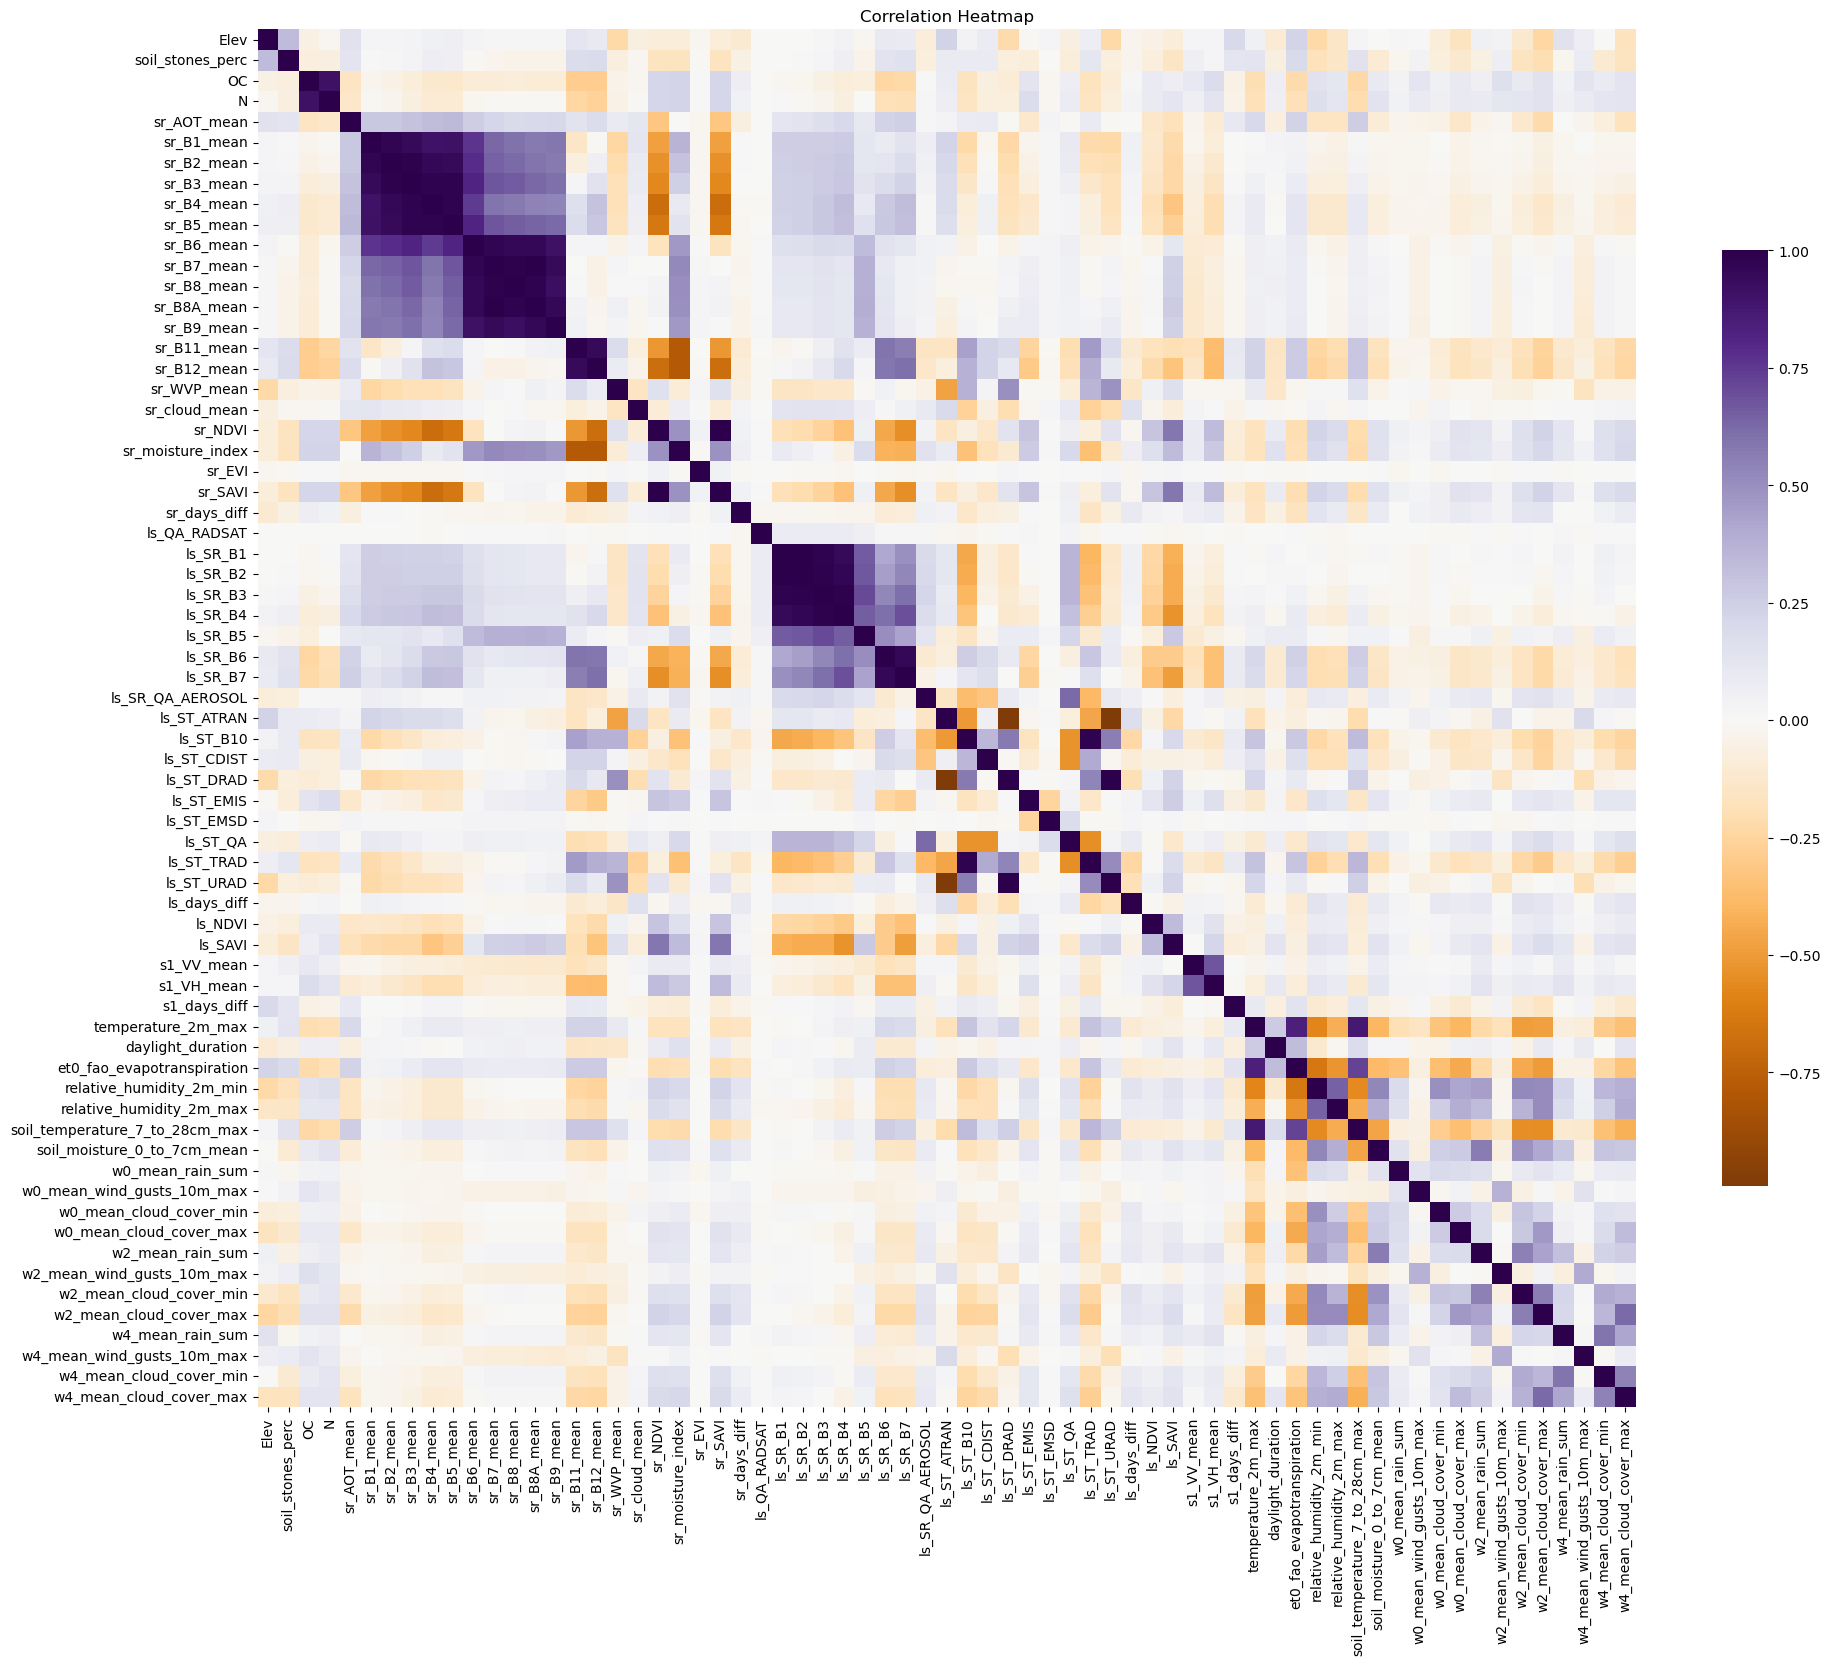

In [422]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
corr_features = [col for col in num_cols if col not in ['point_id', 'survey_date', 'date']]
corr_df = df[corr_features]
# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot as heatmap
plt.figure(figsize=(20, 20))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            # mask=mask, 
            # annot=True, 
            cmap='PuOr', fmt=".2f", square=True,
            cbar_kws={"shrink": 0.5},
    annot_kws={"size": 8})  # 👈 Set font size for annotation numbers)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("./graphs/all/136_aggregations_bytime.png", dpi=300)
plt.show()

# Save as CSV

In [424]:
len(df)

15419

In [425]:
csv_filename = "data/modelling/model_csvs/250814_1647_OC_aggregated_weather.csv"
df.to_csv(csv_filename, index=False)